In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


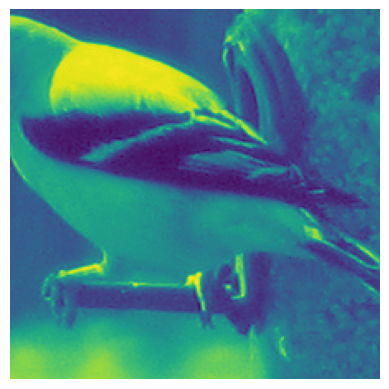

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


Total parametrs:  24511329


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 0.8326


Epoch 1, Batch 2, LR: 0.000050, Loss: 0.8007


Epoch 1, Batch 3, LR: 0.000050, Loss: 0.7287


Epoch 1, Batch 4, LR: 0.000050, Loss: 0.7009


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.6708


Epoch 1, Batch 6, LR: 0.000050, Loss: 0.6648


Epoch 1, Batch 7, LR: 0.000050, Loss: 0.6607


Epoch 1, Batch 8, LR: 0.000050, Loss: 0.6488


Epoch 1, Batch 9, LR: 0.000050, Loss: 0.6299


Epoch 1, Batch 10, LR: 0.000050, Loss: 0.6286


Epoch 1, Batch 11, LR: 0.000050, Loss: 0.6166


Epoch 1, Batch 12, LR: 0.000050, Loss: 0.6064


Epoch 1, Batch 13, LR: 0.000050, Loss: 0.6237


Epoch 1, Batch 14, LR: 0.000050, Loss: 0.6118


Epoch 1, Batch 15, LR: 0.000050, Loss: 0.6270


Epoch 1, Batch 16, LR: 0.000050, Loss: 0.6069


Epoch 1, Batch 17, LR: 0.000050, Loss: 0.5934


Epoch 1, Batch 18, LR: 0.000050, Loss: 0.6023


Epoch 1, Batch 19, LR: 0.000050, Loss: 0.6078


Epoch 1, Batch 20, LR: 0.000050, Loss: 0.6084


Epoch 1, Batch 21, LR: 0.000050, Loss: 0.5829


Epoch 1, Batch 22, LR: 0.000050, Loss: 0.5937


Epoch 1, Batch 23, LR: 0.000050, Loss: 0.5847


Epoch 1, Batch 24, LR: 0.000050, Loss: 0.5959


Epoch 1, Batch 25, LR: 0.000050, Loss: 0.6020


Epoch 1, Batch 26, LR: 0.000050, Loss: 0.5919


Epoch 1, Batch 27, LR: 0.000050, Loss: 0.6016


Epoch 1, Batch 28, LR: 0.000050, Loss: 0.5962


Epoch 1, Batch 29, LR: 0.000050, Loss: 0.5911


Epoch 1, Batch 30, LR: 0.000050, Loss: 0.6052


Epoch 1, Batch 31, LR: 0.000050, Loss: 0.5976


Epoch 1, Batch 32, LR: 0.000049, Loss: 0.5800


Epoch 1, Batch 33, LR: 0.000049, Loss: 0.5805


Epoch 1, Batch 34, LR: 0.000049, Loss: 0.6032


Epoch 1, Batch 35, LR: 0.000049, Loss: 0.5898


Epoch 1, Batch 36, LR: 0.000049, Loss: 0.5904


Epoch 1, Batch 37, LR: 0.000049, Loss: 0.5830


Epoch 1, Batch 38, LR: 0.000049, Loss: 0.5872


Epoch 1, Batch 39, LR: 0.000049, Loss: 0.5900


Epoch 1, Batch 40, LR: 0.000049, Loss: 0.5770


Epoch 1, Batch 41, LR: 0.000049, Loss: 0.5997


Epoch 1, Batch 42, LR: 0.000049, Loss: 0.5898


Epoch 1, Batch 43, LR: 0.000049, Loss: 0.5905


Epoch 1, Batch 44, LR: 0.000049, Loss: 0.5847


Epoch 1, Batch 45, LR: 0.000049, Loss: 0.5651


Epoch 1, Batch 46, LR: 0.000049, Loss: 0.5914


Epoch 1, Batch 47, LR: 0.000049, Loss: 0.5807


Epoch 1, Batch 48, LR: 0.000049, Loss: 0.6046


Epoch 1, Batch 49, LR: 0.000049, Loss: 0.5826


Epoch 1, Batch 50, LR: 0.000049, Loss: 0.5803


Epoch 1, Batch 51, LR: 0.000049, Loss: 0.5869


Epoch 1, Batch 52, LR: 0.000049, Loss: 0.5800


Epoch 1, Batch 53, LR: 0.000049, Loss: 0.5916


Epoch 1, Batch 54, LR: 0.000049, Loss: 0.6026


Epoch 1, Batch 55, LR: 0.000049, Loss: 0.5804


Epoch 1, Batch 56, LR: 0.000048, Loss: 0.5860


Epoch 1, Batch 57, LR: 0.000048, Loss: 0.5839


Epoch 1, Batch 58, LR: 0.000048, Loss: 0.5853


Epoch 1, Batch 59, LR: 0.000048, Loss: 0.5849


Epoch 1, Batch 60, LR: 0.000048, Loss: 0.5793


Epoch 1, Batch 61, LR: 0.000048, Loss: 0.5871


Epoch 1, Batch 62, LR: 0.000048, Loss: 0.5775


Epoch 1, Batch 63, LR: 0.000048, Loss: 0.5958


Epoch 1, Batch 64, LR: 0.000048, Loss: 0.5978


Epoch 1, Batch 65, LR: 0.000048, Loss: 0.5762


Epoch 1, Batch 66, LR: 0.000048, Loss: 0.5700


Epoch 1, Batch 67, LR: 0.000048, Loss: 0.5720


Epoch 1, Batch 68, LR: 0.000048, Loss: 0.5858


Epoch 1, Batch 69, LR: 0.000048, Loss: 0.5756


Epoch 1, Batch 70, LR: 0.000048, Loss: 0.5672


Epoch 1, Batch 71, LR: 0.000048, Loss: 0.5662


Epoch 1, Batch 72, LR: 0.000047, Loss: 0.5921


Epoch 1, Batch 73, LR: 0.000047, Loss: 0.5920


Epoch 1, Batch 74, LR: 0.000047, Loss: 0.5995


Epoch 1, Batch 75, LR: 0.000047, Loss: 0.5982


Epoch 1, Batch 76, LR: 0.000047, Loss: 0.5793


Epoch 1, Batch 77, LR: 0.000047, Loss: 0.5953


Epoch 1, Batch 78, LR: 0.000047, Loss: 0.5662


Epoch 1, Batch 79, LR: 0.000047, Loss: 0.5817


Epoch 1, Batch 80, LR: 0.000047, Loss: 0.5820


Epoch 1, Batch 81, LR: 0.000047, Loss: 0.5754


Epoch 1, Batch 82, LR: 0.000047, Loss: 0.5860


Epoch 1, Batch 83, LR: 0.000047, Loss: 0.5975


Epoch 1, Batch 84, LR: 0.000047, Loss: 0.5872


Epoch 1, Batch 85, LR: 0.000047, Loss: 0.5639


Epoch 1, Batch 86, LR: 0.000046, Loss: 0.5858


Epoch 1, Batch 87, LR: 0.000046, Loss: 0.5804


Epoch 1, Batch 88, LR: 0.000046, Loss: 0.5865


Epoch 1, Batch 89, LR: 0.000046, Loss: 0.5793


Epoch 1, Batch 90, LR: 0.000046, Loss: 0.5891


Epoch 1, Batch 91, LR: 0.000046, Loss: 0.5836


Epoch 1, Batch 92, LR: 0.000046, Loss: 0.5710


Epoch 1, Batch 93, LR: 0.000046, Loss: 0.5904


Epoch 1, Batch 94, LR: 0.000046, Loss: 0.5570


Epoch 1, Batch 95, LR: 0.000046, Loss: 0.5591


Epoch 1, Batch 96, LR: 0.000046, Loss: 0.5835


Epoch 1, Batch 97, LR: 0.000045, Loss: 0.5896


Epoch 1, Batch 98, LR: 0.000045, Loss: 0.5824


Epoch 1, Batch 99, LR: 0.000045, Loss: 0.5789


Epoch 1, Batch 100, LR: 0.000045, Loss: 0.5830


Epoch 1, Batch 101, LR: 0.000045, Loss: 0.5658


Epoch 1, Batch 102, LR: 0.000045, Loss: 0.5963


Epoch 1, Batch 103, LR: 0.000045, Loss: 0.5774


Epoch 1, Batch 104, LR: 0.000045, Loss: 0.5787


Epoch 1, Batch 105, LR: 0.000045, Loss: 0.5714


Epoch 1, Batch 106, LR: 0.000045, Loss: 0.5986


Epoch 1, Batch 107, LR: 0.000045, Loss: 0.5965


Epoch 1, Batch 108, LR: 0.000044, Loss: 0.5881


Epoch 1, Batch 109, LR: 0.000044, Loss: 0.5710


Epoch 1, Batch 110, LR: 0.000044, Loss: 0.5685


Epoch 1, Batch 111, LR: 0.000044, Loss: 0.5784


Epoch 1, Batch 112, LR: 0.000044, Loss: 0.6019


Epoch 1, Batch 113, LR: 0.000044, Loss: 0.5916


Epoch 1, Batch 114, LR: 0.000044, Loss: 0.5824


Epoch 1, Batch 115, LR: 0.000044, Loss: 0.5942


Epoch 1, Batch 116, LR: 0.000044, Loss: 0.5843


Epoch 1, Batch 117, LR: 0.000044, Loss: 0.5911


Epoch 1, Batch 118, LR: 0.000043, Loss: 0.5753


Epoch 1, Batch 119, LR: 0.000043, Loss: 0.5733


Epoch 1, Batch 120, LR: 0.000043, Loss: 0.5738


Epoch 1, Batch 121, LR: 0.000043, Loss: 0.5882


Epoch 1, Batch 122, LR: 0.000043, Loss: 0.5749


Epoch 1, Batch 123, LR: 0.000043, Loss: 0.5685


Epoch 1, Batch 124, LR: 0.000043, Loss: 0.5804


Epoch 1, Batch 125, LR: 0.000043, Loss: 0.5779


Epoch 1, Batch 126, LR: 0.000043, Loss: 0.5875


Epoch 1, Batch 127, LR: 0.000042, Loss: 0.5690


Epoch 1, Batch 128, LR: 0.000042, Loss: 0.5825


Epoch 1, Batch 129, LR: 0.000042, Loss: 0.5923


Epoch 1, Batch 130, LR: 0.000042, Loss: 0.5824


Epoch 1, Batch 131, LR: 0.000042, Loss: 0.5846


Epoch 1, Batch 132, LR: 0.000042, Loss: 0.5839


Epoch 1, Batch 133, LR: 0.000042, Loss: 0.5792


Epoch 1, Batch 134, LR: 0.000042, Loss: 0.5844


Epoch 1, Batch 135, LR: 0.000042, Loss: 0.5710


Epoch 1, Batch 136, LR: 0.000041, Loss: 0.5681


Epoch 1, Batch 137, LR: 0.000041, Loss: 0.5775


Epoch 1, Batch 138, LR: 0.000041, Loss: 0.5942


Epoch 1, Batch 139, LR: 0.000041, Loss: 0.5796


Epoch 1, Batch 140, LR: 0.000041, Loss: 0.5634


Epoch 1, Batch 141, LR: 0.000041, Loss: 0.5859


Epoch 1, Batch 142, LR: 0.000041, Loss: 0.5572


Epoch 1, Batch 143, LR: 0.000041, Loss: 0.5728


Epoch 1, Batch 144, LR: 0.000040, Loss: 0.5657


Epoch 1, Batch 145, LR: 0.000040, Loss: 0.5858


Epoch 1, Batch 146, LR: 0.000040, Loss: 0.5861


Epoch 1, Batch 147, LR: 0.000040, Loss: 0.5753


Epoch 1, Batch 148, LR: 0.000040, Loss: 0.5814


Epoch 1, Batch 149, LR: 0.000040, Loss: 0.5693


Epoch 1, Batch 150, LR: 0.000040, Loss: 0.5845


Epoch 1, Batch 151, LR: 0.000040, Loss: 0.5946


Epoch 1, Batch 152, LR: 0.000039, Loss: 0.5844


Epoch 1, Batch 153, LR: 0.000039, Loss: 0.5704


Epoch 1, Batch 154, LR: 0.000039, Loss: 0.5843


Epoch 1, Batch 155, LR: 0.000039, Loss: 0.6029


Epoch 1, Batch 156, LR: 0.000039, Loss: 0.5540


Epoch 1, Batch 157, LR: 0.000039, Loss: 0.5767


Epoch 1, Batch 158, LR: 0.000039, Loss: 0.5679


Epoch 1, Batch 159, LR: 0.000039, Loss: 0.5810


Epoch 1, Batch 160, LR: 0.000038, Loss: 0.5937


Epoch 1, Batch 161, LR: 0.000038, Loss: 0.5803


Epoch 1, Batch 162, LR: 0.000038, Loss: 0.5733


Epoch 1, Batch 163, LR: 0.000038, Loss: 0.5834


Epoch 1, Batch 164, LR: 0.000038, Loss: 0.5861


Epoch 1, Batch 165, LR: 0.000038, Loss: 0.5810


Epoch 1, Batch 166, LR: 0.000038, Loss: 0.5713


Epoch 1, Batch 167, LR: 0.000037, Loss: 0.5775


Epoch 1, Batch 168, LR: 0.000037, Loss: 0.5823


Epoch 1, Batch 169, LR: 0.000037, Loss: 0.5801


Epoch 1, Batch 170, LR: 0.000037, Loss: 0.5600


Epoch 1, Batch 171, LR: 0.000037, Loss: 0.5739


Epoch 1, Batch 172, LR: 0.000037, Loss: 0.5820


Epoch 1, Batch 173, LR: 0.000037, Loss: 0.5690


Epoch 1, Batch 174, LR: 0.000036, Loss: 0.5762


Epoch 1, Batch 175, LR: 0.000036, Loss: 0.5937


Epoch 1, Batch 176, LR: 0.000036, Loss: 0.5628


Epoch 1, Batch 177, LR: 0.000036, Loss: 0.6071


Epoch 1, Batch 178, LR: 0.000036, Loss: 0.5669


Epoch 1, Batch 179, LR: 0.000036, Loss: 0.5855


Epoch 1, Batch 180, LR: 0.000036, Loss: 0.5483


Epoch 1, Batch 181, LR: 0.000036, Loss: 0.5855


Epoch 1, Batch 182, LR: 0.000035, Loss: 0.5747


Epoch 1, Batch 183, LR: 0.000035, Loss: 0.5725


Epoch 1, Batch 184, LR: 0.000035, Loss: 0.5567


Epoch 1, Batch 185, LR: 0.000035, Loss: 0.5859


Epoch 1, Batch 186, LR: 0.000035, Loss: 0.5838


Epoch 1, Batch 187, LR: 0.000035, Loss: 0.5864


Epoch 1, Batch 188, LR: 0.000034, Loss: 0.5649


Epoch 1, Batch 189, LR: 0.000034, Loss: 0.5794


Epoch 1, Batch 190, LR: 0.000034, Loss: 0.5848


Epoch 1, Batch 191, LR: 0.000034, Loss: 0.5578


Epoch 1, Batch 192, LR: 0.000034, Loss: 0.5648


Epoch 1, Batch 193, LR: 0.000034, Loss: 0.5829


Epoch 1, Batch 194, LR: 0.000034, Loss: 0.5750


Epoch 1, Batch 195, LR: 0.000033, Loss: 0.5651


Epoch 1, Batch 196, LR: 0.000033, Loss: 0.5891


Epoch 1, Batch 197, LR: 0.000033, Loss: 0.5686


Epoch 1, Batch 198, LR: 0.000033, Loss: 0.5954


Epoch 1, Batch 199, LR: 0.000033, Loss: 0.5983


Epoch 1, Batch 200, LR: 0.000033, Loss: 0.5577


Epoch 1, Batch 201, LR: 0.000033, Loss: 0.5752


Epoch 1, Batch 202, LR: 0.000032, Loss: 0.5774


Epoch 1, Batch 203, LR: 0.000032, Loss: 0.5843


Epoch 1, Batch 204, LR: 0.000032, Loss: 0.5720


Epoch 1, Batch 205, LR: 0.000032, Loss: 0.5648


Epoch 1, Batch 206, LR: 0.000032, Loss: 0.5770


Epoch 1, Batch 207, LR: 0.000032, Loss: 0.5964


Epoch 1, Batch 208, LR: 0.000032, Loss: 0.5833


Epoch 1, Batch 209, LR: 0.000031, Loss: 0.5817


Epoch 1, Batch 210, LR: 0.000031, Loss: 0.5955


Epoch 1, Batch 211, LR: 0.000031, Loss: 0.5785


Epoch 1, Batch 212, LR: 0.000031, Loss: 0.5896


Epoch 1, Batch 213, LR: 0.000031, Loss: 0.6028


Epoch 1, Batch 214, LR: 0.000031, Loss: 0.5774


Epoch 1, Batch 215, LR: 0.000030, Loss: 0.5689


Epoch 1, Batch 216, LR: 0.000030, Loss: 0.5709


Epoch 1, Batch 217, LR: 0.000030, Loss: 0.5712


Epoch 1, Batch 218, LR: 0.000030, Loss: 0.5597


Epoch 1, Batch 219, LR: 0.000030, Loss: 0.5731


Epoch 1, Batch 220, LR: 0.000030, Loss: 0.5815


Epoch 1, Batch 221, LR: 0.000030, Loss: 0.5724


Epoch 1, Batch 222, LR: 0.000029, Loss: 0.5820


Epoch 1, Batch 223, LR: 0.000029, Loss: 0.5648


Epoch 1, Batch 224, LR: 0.000029, Loss: 0.5741


Epoch 1, Batch 225, LR: 0.000029, Loss: 0.5649


Epoch 1, Batch 226, LR: 0.000029, Loss: 0.5834


Epoch 1, Batch 227, LR: 0.000029, Loss: 0.5721


Epoch 1, Batch 228, LR: 0.000028, Loss: 0.5708


Epoch 1, Batch 229, LR: 0.000028, Loss: 0.5775


Epoch 1, Batch 230, LR: 0.000028, Loss: 0.5821


Epoch 1, Batch 231, LR: 0.000028, Loss: 0.5785


Epoch 1, Batch 232, LR: 0.000028, Loss: 0.5856


Epoch 1, Batch 233, LR: 0.000028, Loss: 0.5980


Epoch 1, Batch 234, LR: 0.000028, Loss: 0.5823


Epoch 1, Batch 235, LR: 0.000027, Loss: 0.5676


Epoch 1, Batch 236, LR: 0.000027, Loss: 0.5664


Epoch 1, Batch 237, LR: 0.000027, Loss: 0.5720


Epoch 1, Batch 238, LR: 0.000027, Loss: 0.5724


Epoch 1, Batch 239, LR: 0.000027, Loss: 0.5707


Epoch 1, Batch 240, LR: 0.000027, Loss: 0.5824


Epoch 1, Batch 241, LR: 0.000026, Loss: 0.5881


Epoch 1, Batch 242, LR: 0.000026, Loss: 0.5757


Epoch 1, Batch 243, LR: 0.000026, Loss: 0.5943


Epoch 1, Batch 244, LR: 0.000026, Loss: 0.5749


Epoch 1, Batch 245, LR: 0.000026, Loss: 0.5567


Epoch 1, Batch 246, LR: 0.000026, Loss: 0.5705


Epoch 1, Batch 247, LR: 0.000025, Loss: 0.5714


Epoch 1, Batch 248, LR: 0.000025, Loss: 0.5711


Epoch 1, Batch 249, LR: 0.000025, Loss: 0.5769


Epoch 1, Batch 250, LR: 0.000025, Loss: 0.5766


Epoch 1, Batch 251, LR: 0.000025, Loss: 0.5676


Epoch 1, Batch 252, LR: 0.000025, Loss: 0.5844


Epoch 1, Batch 253, LR: 0.000025, Loss: 0.5554


Epoch 1, Batch 254, LR: 0.000024, Loss: 0.5631


Epoch 1, Batch 255, LR: 0.000024, Loss: 0.5538


Epoch 1, Batch 256, LR: 0.000024, Loss: 0.5842


Epoch 1, Batch 257, LR: 0.000024, Loss: 0.5850


Epoch 1, Batch 258, LR: 0.000024, Loss: 0.5947


Epoch 1, Batch 259, LR: 0.000024, Loss: 0.5953


Epoch 1, Batch 260, LR: 0.000023, Loss: 0.5804


Epoch 1, Batch 261, LR: 0.000023, Loss: 0.5960


Epoch 1, Batch 262, LR: 0.000023, Loss: 0.5899


Epoch 1, Batch 263, LR: 0.000023, Loss: 0.5812


Epoch 1, Batch 264, LR: 0.000023, Loss: 0.5819


Epoch 1, Batch 265, LR: 0.000023, Loss: 0.5731


Epoch 1, Batch 266, LR: 0.000022, Loss: 0.5844


Epoch 1, Batch 267, LR: 0.000022, Loss: 0.5758


Epoch 1, Batch 268, LR: 0.000022, Loss: 0.5803


Epoch 1, Batch 269, LR: 0.000022, Loss: 0.5856


Epoch 1, Batch 270, LR: 0.000022, Loss: 0.5859


Epoch 1, Batch 271, LR: 0.000022, Loss: 0.5816


Epoch 1, Batch 272, LR: 0.000022, Loss: 0.5668


Epoch 1, Batch 273, LR: 0.000021, Loss: 0.5662


Epoch 1, Batch 274, LR: 0.000021, Loss: 0.5688


Epoch 1, Batch 275, LR: 0.000021, Loss: 0.5675


Epoch 1, Batch 276, LR: 0.000021, Loss: 0.5745


Epoch 1, Batch 277, LR: 0.000021, Loss: 0.5751


Epoch 1, Batch 278, LR: 0.000021, Loss: 0.5782


Epoch 1, Batch 279, LR: 0.000020, Loss: 0.5601


Epoch 1, Batch 280, LR: 0.000020, Loss: 0.5771


Epoch 1, Batch 281, LR: 0.000020, Loss: 0.5661


Epoch 1, Batch 282, LR: 0.000020, Loss: 0.5873


Epoch 1, Batch 283, LR: 0.000020, Loss: 0.5746


Epoch 1, Batch 284, LR: 0.000020, Loss: 0.5948


Epoch 1, Batch 285, LR: 0.000020, Loss: 0.5789


Epoch 1, Batch 286, LR: 0.000019, Loss: 0.5741


Epoch 1, Batch 287, LR: 0.000019, Loss: 0.5856


Epoch 1, Batch 288, LR: 0.000019, Loss: 0.5772


Epoch 1, Batch 289, LR: 0.000019, Loss: 0.5642


Epoch 1, Batch 290, LR: 0.000019, Loss: 0.5558


Epoch 1, Batch 291, LR: 0.000019, Loss: 0.5772


Epoch 1, Batch 292, LR: 0.000018, Loss: 0.5799


Epoch 1, Batch 293, LR: 0.000018, Loss: 0.5697


Epoch 1, Batch 294, LR: 0.000018, Loss: 0.5967


Epoch 1, Batch 295, LR: 0.000018, Loss: 0.5692


Epoch 1, Batch 296, LR: 0.000018, Loss: 0.5572


Epoch 1, Batch 297, LR: 0.000018, Loss: 0.5798


Epoch 1, Batch 298, LR: 0.000018, Loss: 0.5796


Epoch 1, Batch 299, LR: 0.000017, Loss: 0.5577


Epoch 1, Batch 300, LR: 0.000017, Loss: 0.5831


Epoch 1, Batch 301, LR: 0.000017, Loss: 0.5668


Epoch 1, Batch 302, LR: 0.000017, Loss: 0.5789


Epoch 1, Batch 303, LR: 0.000017, Loss: 0.5763


Epoch 1, Batch 304, LR: 0.000017, Loss: 0.5515


Epoch 1, Batch 305, LR: 0.000017, Loss: 0.5928


Epoch 1, Batch 306, LR: 0.000016, Loss: 0.5684


Epoch 1, Batch 307, LR: 0.000016, Loss: 0.5731


Epoch 1, Batch 308, LR: 0.000016, Loss: 0.5905


Epoch 1, Batch 309, LR: 0.000016, Loss: 0.5946


Epoch 1, Batch 310, LR: 0.000016, Loss: 0.5877


Epoch 1, Batch 311, LR: 0.000016, Loss: 0.5784


Epoch 1, Batch 312, LR: 0.000016, Loss: 0.5691


Epoch 1, Batch 313, LR: 0.000015, Loss: 0.5700


Epoch 1, Batch 314, LR: 0.000015, Loss: 0.5805


Epoch 1, Batch 315, LR: 0.000015, Loss: 0.5672


Epoch 1, Batch 316, LR: 0.000015, Loss: 0.5703


Epoch 1, Batch 317, LR: 0.000015, Loss: 0.5714


Epoch 1, Batch 318, LR: 0.000015, Loss: 0.5676


Epoch 1, Batch 319, LR: 0.000014, Loss: 0.5869


Epoch 1, Batch 320, LR: 0.000014, Loss: 0.5770


Epoch 1, Batch 321, LR: 0.000014, Loss: 0.5730


Epoch 1, Batch 322, LR: 0.000014, Loss: 0.5840


Epoch 1, Batch 323, LR: 0.000014, Loss: 0.5598


Epoch 1, Batch 324, LR: 0.000014, Loss: 0.5793


Epoch 1, Batch 325, LR: 0.000014, Loss: 0.5872


Epoch 1, Batch 326, LR: 0.000014, Loss: 0.5717


Epoch 1, Batch 327, LR: 0.000013, Loss: 0.5842


Epoch 1, Batch 328, LR: 0.000013, Loss: 0.5778


Epoch 1, Batch 329, LR: 0.000013, Loss: 0.5805


Epoch 1, Batch 330, LR: 0.000013, Loss: 0.5708


Epoch 1, Batch 331, LR: 0.000013, Loss: 0.5740


Epoch 1, Batch 332, LR: 0.000013, Loss: 0.5672


Epoch 1, Batch 333, LR: 0.000013, Loss: 0.5870


Epoch 1, Batch 334, LR: 0.000012, Loss: 0.5539


Epoch 1, Batch 335, LR: 0.000012, Loss: 0.5843


Epoch 1, Batch 336, LR: 0.000012, Loss: 0.5838


Epoch 1, Batch 337, LR: 0.000012, Loss: 0.5873


Epoch 1, Batch 338, LR: 0.000012, Loss: 0.5801


Epoch 1, Batch 339, LR: 0.000012, Loss: 0.5749


Epoch 1, Batch 340, LR: 0.000012, Loss: 0.5785


Epoch 1, Batch 341, LR: 0.000011, Loss: 0.5732


Epoch 1, Batch 342, LR: 0.000011, Loss: 0.5818


Epoch 1, Batch 343, LR: 0.000011, Loss: 0.5760


Epoch 1, Batch 344, LR: 0.000011, Loss: 0.5642


Epoch 1, Batch 345, LR: 0.000011, Loss: 0.5687


Epoch 1, Batch 346, LR: 0.000011, Loss: 0.5839


Epoch 1, Batch 347, LR: 0.000011, Loss: 0.5597


Epoch 1, Batch 348, LR: 0.000011, Loss: 0.5684


Epoch 1, Batch 349, LR: 0.000010, Loss: 0.5760


Epoch 1, Batch 350, LR: 0.000010, Loss: 0.5677


Epoch 1, Batch 351, LR: 0.000010, Loss: 0.5672


Epoch 1, Batch 352, LR: 0.000010, Loss: 0.5685


Epoch 1, Batch 353, LR: 0.000010, Loss: 0.5790


Epoch 1, Batch 354, LR: 0.000010, Loss: 0.5874


Epoch 1, Batch 355, LR: 0.000010, Loss: 0.5783


Epoch 1, Batch 356, LR: 0.000010, Loss: 0.5873


Epoch 1, Batch 357, LR: 0.000009, Loss: 0.5787


Epoch 1, Batch 358, LR: 0.000009, Loss: 0.5662


Epoch 1, Batch 359, LR: 0.000009, Loss: 0.5816


Epoch 1, Batch 360, LR: 0.000009, Loss: 0.5771


Epoch 1, Batch 361, LR: 0.000009, Loss: 0.5870


Epoch 1, Batch 362, LR: 0.000009, Loss: 0.5533


Epoch 1, Batch 363, LR: 0.000009, Loss: 0.5657


Epoch 1, Batch 364, LR: 0.000009, Loss: 0.5910


Epoch 1, Batch 365, LR: 0.000008, Loss: 0.5767


Epoch 1, Batch 366, LR: 0.000008, Loss: 0.5841


Epoch 1, Batch 367, LR: 0.000008, Loss: 0.5761


Epoch 1, Batch 368, LR: 0.000008, Loss: 0.5596


Epoch 1, Batch 369, LR: 0.000008, Loss: 0.5668


Epoch 1, Batch 370, LR: 0.000008, Loss: 0.5670


Epoch 1, Batch 371, LR: 0.000008, Loss: 0.5766


Epoch 1, Batch 372, LR: 0.000008, Loss: 0.5656


Epoch 1, Batch 373, LR: 0.000008, Loss: 0.5863


Epoch 1, Batch 374, LR: 0.000007, Loss: 0.5773


Epoch 1, Batch 375, LR: 0.000007, Loss: 0.5826


Epoch 1, Batch 376, LR: 0.000007, Loss: 0.5743


Epoch 1, Batch 377, LR: 0.000007, Loss: 0.5908


Epoch 1, Batch 378, LR: 0.000007, Loss: 0.5861


Epoch 1, Batch 379, LR: 0.000007, Loss: 0.5845


Epoch 1, Batch 380, LR: 0.000007, Loss: 0.5850


Epoch 1, Batch 381, LR: 0.000007, Loss: 0.5732


Epoch 1, Batch 382, LR: 0.000007, Loss: 0.5880


Epoch 1, Batch 383, LR: 0.000006, Loss: 0.5673


Epoch 1, Batch 384, LR: 0.000006, Loss: 0.5777


Epoch 1, Batch 385, LR: 0.000006, Loss: 0.5899


Epoch 1, Batch 386, LR: 0.000006, Loss: 0.5797


Epoch 1, Batch 387, LR: 0.000006, Loss: 0.5685


Epoch 1, Batch 388, LR: 0.000006, Loss: 0.5843


Epoch 1, Batch 389, LR: 0.000006, Loss: 0.5845


Epoch 1, Batch 390, LR: 0.000006, Loss: 0.5781


Epoch 1, Batch 391, LR: 0.000006, Loss: 0.5694


Epoch 1, Batch 392, LR: 0.000006, Loss: 0.5640


Epoch 1, Batch 393, LR: 0.000005, Loss: 0.5635


Epoch 1, Batch 394, LR: 0.000005, Loss: 0.5808


Epoch 1, Batch 395, LR: 0.000005, Loss: 0.5832


Epoch 1, Batch 396, LR: 0.000005, Loss: 0.5668


Epoch 1, Batch 397, LR: 0.000005, Loss: 0.5871


Epoch 1, Batch 398, LR: 0.000005, Loss: 0.5855


Epoch 1, Batch 399, LR: 0.000005, Loss: 0.5894


Epoch 1, Batch 400, LR: 0.000005, Loss: 0.5783


Epoch 1, Batch 401, LR: 0.000005, Loss: 0.5588


Epoch 1, Batch 402, LR: 0.000005, Loss: 0.5689


Epoch 1, Batch 403, LR: 0.000005, Loss: 0.5810


Epoch 1, Batch 404, LR: 0.000004, Loss: 0.5773


Epoch 1, Batch 405, LR: 0.000004, Loss: 0.5764


Epoch 1, Batch 406, LR: 0.000004, Loss: 0.5628


Epoch 1, Batch 407, LR: 0.000004, Loss: 0.5699


Epoch 1, Batch 408, LR: 0.000004, Loss: 0.5782


Epoch 1, Batch 409, LR: 0.000004, Loss: 0.5922


Epoch 1, Batch 410, LR: 0.000004, Loss: 0.5829


Epoch 1, Batch 411, LR: 0.000004, Loss: 0.5822


Epoch 1, Batch 412, LR: 0.000004, Loss: 0.5691


Epoch 1, Batch 413, LR: 0.000004, Loss: 0.5783


Epoch 1, Batch 414, LR: 0.000004, Loss: 0.5646


Epoch 1, Batch 415, LR: 0.000003, Loss: 0.5718


Epoch 1, Batch 416, LR: 0.000003, Loss: 0.5746


Epoch 1, Batch 417, LR: 0.000003, Loss: 0.5668


Epoch 1, Batch 418, LR: 0.000003, Loss: 0.5641


Epoch 1, Batch 419, LR: 0.000003, Loss: 0.5736


Epoch 1, Batch 420, LR: 0.000003, Loss: 0.5860


Epoch 1, Batch 421, LR: 0.000003, Loss: 0.5847


Epoch 1, Batch 422, LR: 0.000003, Loss: 0.5659


Epoch 1, Batch 423, LR: 0.000003, Loss: 0.5855


Epoch 1, Batch 424, LR: 0.000003, Loss: 0.5675


Epoch 1, Batch 425, LR: 0.000003, Loss: 0.5705


Epoch 1, Batch 426, LR: 0.000003, Loss: 0.5748


Epoch 1, Batch 427, LR: 0.000003, Loss: 0.5806


Epoch 1, Batch 428, LR: 0.000003, Loss: 0.5868


Epoch 1, Batch 429, LR: 0.000002, Loss: 0.5777


Epoch 1, Batch 430, LR: 0.000002, Loss: 0.5792


Epoch 1, Batch 431, LR: 0.000002, Loss: 0.5482


Epoch 1, Batch 432, LR: 0.000002, Loss: 0.5780


Epoch 1, Batch 433, LR: 0.000002, Loss: 0.5810


Epoch 1, Batch 434, LR: 0.000002, Loss: 0.5838


Epoch 1, Batch 435, LR: 0.000002, Loss: 0.5578


Epoch 1, Batch 436, LR: 0.000002, Loss: 0.5678


Epoch 1, Batch 437, LR: 0.000002, Loss: 0.5753


Epoch 1, Batch 438, LR: 0.000002, Loss: 0.5677


Epoch 1, Batch 439, LR: 0.000002, Loss: 0.5860


Epoch 1, Batch 440, LR: 0.000002, Loss: 0.5692


Epoch 1, Batch 441, LR: 0.000002, Loss: 0.5847


Epoch 1, Batch 442, LR: 0.000002, Loss: 0.5720


Epoch 1, Batch 443, LR: 0.000002, Loss: 0.5646


Epoch 1, Batch 444, LR: 0.000002, Loss: 0.5627


Epoch 1, Batch 445, LR: 0.000001, Loss: 0.5568


Epoch 1, Batch 446, LR: 0.000001, Loss: 0.5839


Epoch 1, Batch 447, LR: 0.000001, Loss: 0.5827


Epoch 1, Batch 448, LR: 0.000001, Loss: 0.5724


Epoch 1, Batch 449, LR: 0.000001, Loss: 0.5745


Epoch 1, Batch 450, LR: 0.000001, Loss: 0.5445


Epoch 1, Batch 451, LR: 0.000001, Loss: 0.5745


Epoch 1, Batch 452, LR: 0.000001, Loss: 0.5706


Epoch 1, Batch 453, LR: 0.000001, Loss: 0.5842


Epoch 1, Batch 454, LR: 0.000001, Loss: 0.5659


Epoch 1, Batch 455, LR: 0.000001, Loss: 0.5941


Epoch 1, Batch 456, LR: 0.000001, Loss: 0.5876


Epoch 1, Batch 457, LR: 0.000001, Loss: 0.5786


Epoch 1, Batch 458, LR: 0.000001, Loss: 0.5813


Epoch 1, Batch 459, LR: 0.000001, Loss: 0.5796


Epoch 1, Batch 460, LR: 0.000001, Loss: 0.5711


Epoch 1, Batch 461, LR: 0.000001, Loss: 0.5833


Epoch 1, Batch 462, LR: 0.000001, Loss: 0.5685


Epoch 1, Batch 463, LR: 0.000001, Loss: 0.5805


Epoch 1, Batch 464, LR: 0.000001, Loss: 0.5885


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.6003


Epoch 1, Batch 466, LR: 0.000001, Loss: 0.5647


Epoch 1, Batch 467, LR: 0.000001, Loss: 0.5566


Epoch 1, Batch 468, LR: 0.000001, Loss: 0.5742


Epoch 1, Batch 469, LR: 0.000000, Loss: 0.5708


Epoch 1, Batch 470, LR: 0.000000, Loss: 0.5943


Epoch 1, Batch 471, LR: 0.000000, Loss: 0.5790


Epoch 1, Batch 472, LR: 0.000000, Loss: 0.6012


Epoch 1, Batch 473, LR: 0.000000, Loss: 0.5633


Epoch 1, Batch 474, LR: 0.000000, Loss: 0.5755


Epoch 1, Batch 475, LR: 0.000000, Loss: 0.5898


Epoch 1, Batch 476, LR: 0.000000, Loss: 0.5692


Epoch 1, Batch 477, LR: 0.000000, Loss: 0.5689


Epoch 1, Batch 478, LR: 0.000000, Loss: 0.5787


Epoch 1, Batch 479, LR: 0.000000, Loss: 0.5886


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5897


Epoch 1, Batch 481, LR: 0.000000, Loss: 0.5724


Epoch 1, Batch 482, LR: 0.000000, Loss: 0.5600


Epoch 1, Batch 483, LR: 0.000000, Loss: 0.5687


Epoch 1, Batch 484, LR: 0.000000, Loss: 0.5785


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5809


Epoch 1, Batch 486, LR: 0.000000, Loss: 0.5875


Epoch 1, Batch 487, LR: 0.000000, Loss: 0.5745


Epoch 1, Batch 488, LR: 0.000000, Loss: 0.5866


Epoch 1, Batch 489, LR: 0.000000, Loss: 0.5661


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5904


Epoch 1, Batch 491, LR: 0.000000, Loss: 0.5800


Epoch 1, Batch 492, LR: 0.000000, Loss: 0.5879


Epoch 1, Batch 493, LR: 0.000000, Loss: 0.5851


Epoch 1, Batch 494, LR: 0.000000, Loss: 0.5702


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5699


Epoch 1, Batch 496, LR: 0.000000, Loss: 0.5679


Epoch 1, Batch 497, LR: 0.000000, Loss: 0.5642


Epoch 1, Batch 498, LR: 0.000000, Loss: 0.5712


Epoch 1, Batch 499, LR: 0.000000, Loss: 0.5824


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5728


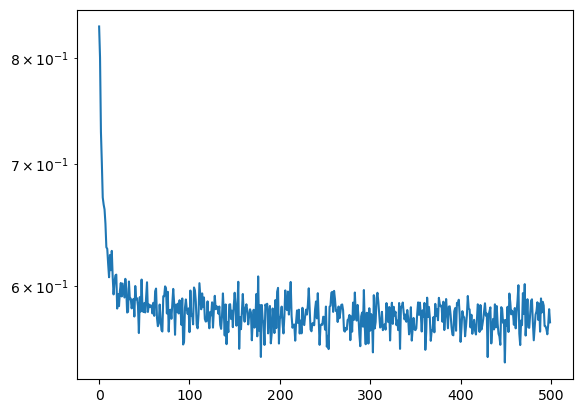

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:21,  2.41s/it]

 20%|██        | 2/10 [00:04<00:18,  2.32s/it]

 30%|███       | 3/10 [00:06<00:15,  2.28s/it]

 40%|████      | 4/10 [00:09<00:13,  2.24s/it]

 50%|█████     | 5/10 [00:11<00:11,  2.21s/it]

 60%|██████    | 6/10 [00:13<00:08,  2.20s/it]

 70%|███████   | 7/10 [00:15<00:06,  2.19s/it]

 80%|████████  | 8/10 [00:17<00:04,  2.19s/it]

 90%|█████████ | 9/10 [00:20<00:02,  2.38s/it]

100%|██████████| 10/10 [00:23<00:00,  2.44s/it]

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]

Test Loss: 0.5764


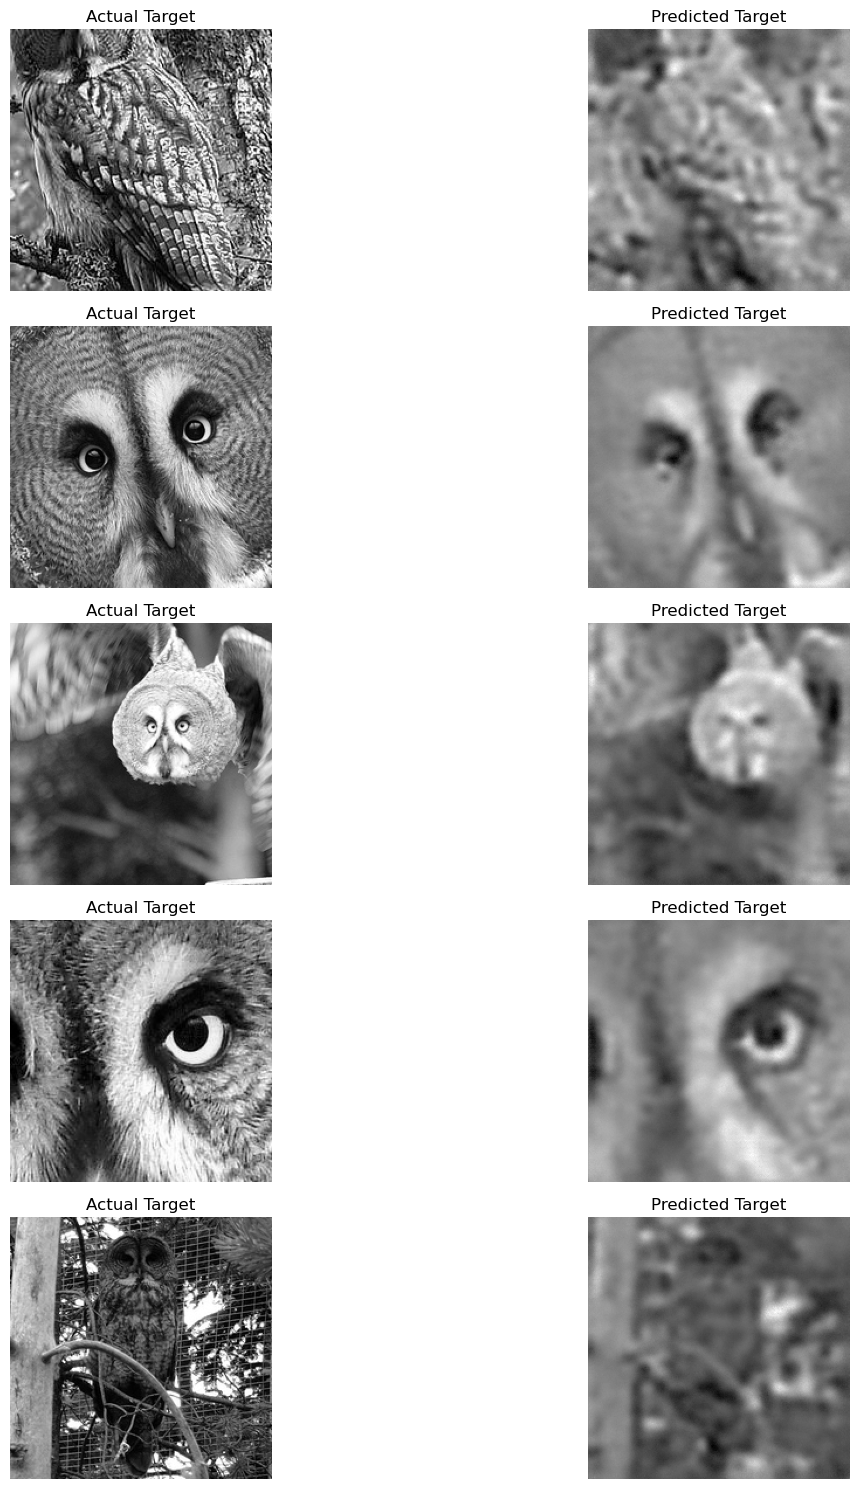

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-7.0888) tensor(5.6411)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))